In [43]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.statistics import Summary, CloneComparison
from modules.statistics import BoxPlot

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
# load data
data_path = '../data/clean_data.json'
with open(data_path, 'r') as f:
    df = pd.read_json(f)
        
# filter cells
print('before', len(df))
df = df[df.genotype.isin((0,1,2))]
df = df[df.near_furrow==True]
#df = df[~df.boundary]
#df = df[df.concurrent_all]
print('after', len(df))

#resampled = resample_df(df)

before 100394
after 36161


(-0.2, 1.5)

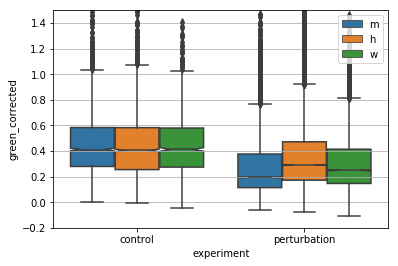

In [75]:
bp = BoxPlot(df, y='green_corrected')
ax = bp.fig.axes[0]
ax.set_ylim(-0.2, 1.5)

In [76]:
_ = Summary(df)

TEST: MW
Control: 0x vs 1x: 0.0718
Control: 1x vs 2x: 0.4818
Mutant: 0x vs 1x: 0.0000
Mutant: 1x vs 2x: 0.0000


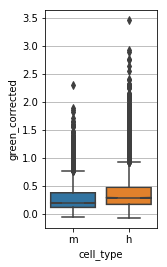

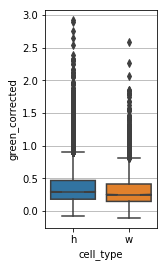

In [77]:
fig = CloneComparison(df, 'perturbation', 'm', 'h').plot()
fig = CloneComparison(df, 'perturbation', 'h', 'w').plot()

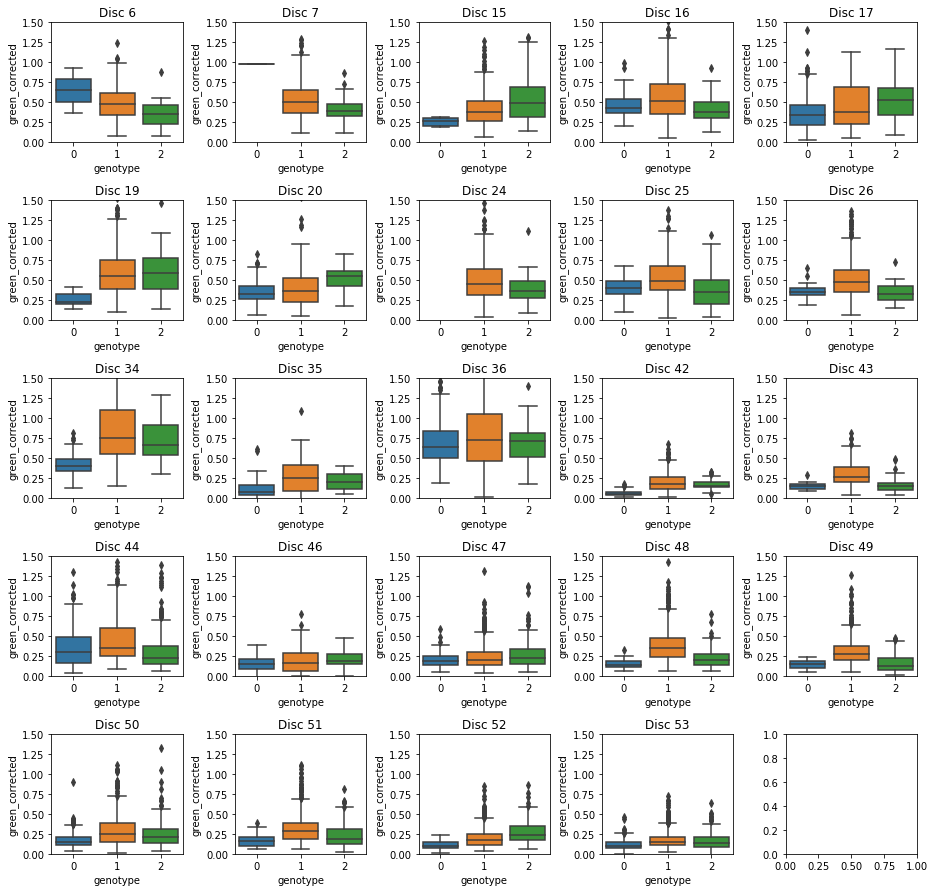

In [36]:
import seaborn as sns
exp = df[df.experiment=='perturbation']
gb = exp.groupby(by=('disc_id'))
nlayers = len(gb.indices)
nrows = (nlayers // 5)+1
fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(13, nrows*2.5))
for i, ind in enumerate(gb.indices.values()):
    ax = axes.ravel()[i]
    cells = exp.iloc[ind]
    
    sns.boxplot(x='genotype', y='green_corrected', data=cells, order=(0,1,2),  ax=ax)
    #sns.violinplot(x='genotype', y='green_corrected', data=cells, order=(0,1,2),  ax=ax)
    
    disc_id = cells.disc_id.unique()[0]
    ax.set_title('Disc {}'.format(disc_id))
    ax.set_ylim(0, 1.5)
    
plt.tight_layout()

In [7]:
""" Detrending about resampled trend """

' Detrending about resampled trend '

In [ ]:
from modules.moving_averages import savgol_filter, get_running_mean
from scipy.interpolate import interp1d

def fit_trendline(cells, size=100000):
    try:
        pop = [resample(cells[cells.genotype==g], size=size) for g in cells.genotype.unique()]
    except:
        print(len(cells[cells.genotype==0]))
        print(len(cells[cells.genotype==1]))
        print(len(cells[cells.genotype==2]))
    mix = pd.concat(pop)
    mix = mix.sort_values('centroid_x')
    #ma = savgol_filter(mix.green_corrected, size+1, 3)
    window_size = int((size*3)/5)
    ma_x = get_running_mean(mix.centroid_x.values, window_size=window_size)
    ma_y = get_running_mean(mix.green_corrected.values, window_size=window_size)
    trend = interp1d(ma_x, ma_y, bounds_error=False, fill_value=(ma_y[0], ma_y[-1]))
    return trend

for exp_id in df.experiment.unique():
    exp = df[df.experiment==exp_id]
    for disc_id in exp.disc_id.unique():
        disc = exp[exp.disc_id==disc_id]
        for layer_id in disc.layer.unique():
            layer = disc[disc.layer==layer_id]
            cells = layer.sort_values('centroid_x')                
            model = fit_trendline(cells)
            trend = model(cells.centroid_x)
            
#             fig, ax = plt.subplots()
#             ax.plot(cells.centroid_x, trend, '-r')
#             ax.set_ylim(0, 2)
#             ax.scatter(cells.centroid_x, cells.green_corrected, s=1)
            
            residuals = cells.green_corrected - trend
            df.loc[cells.index, 'gc_residuals_res'] = residuals
            df.loc[cells.index, 'gc_detrended_res'] = residuals / trend

# Figures

In [61]:
tickpad = 0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['xtick.major.pad'] = tickpad
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['ytick.major.pad'] = tickpad
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['ytick.direction'] = 'out'

In [65]:
control = df[df.experiment=='control']
mutant = df[df.experiment=='perturbation']

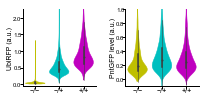

In [68]:
fig = statistics_figure(mutant, variable='green_corrected')
#fig.savefig('../graphics/statistics_perturbation.pdf', dpi=300, format='pdf', transparent=True, rasterized=False)

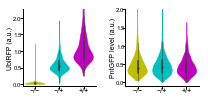

In [83]:
fig = statistics_figure(control, variable='green_corrected')
#fig.savefig('../graphics/statistics_control.pdf', dpi=300, format='pdf', transparent=True, rasterized=False)

In [82]:
def statistics_figure(df, variable='green_corrected'):

    # create axes and define colors
    fig, axes = plt.subplots(ncols=2, figsize=(3, 1.5))
    ax0, ax1 = axes

    kw = dict(scale='width', cut=0)

    # add UbiRFP strip plot
    comparison_plot(df, ax0, groupby='genotype', variable='red', 
               ymax=2.25, statistics=False, markersize=1.5, **kw)
    ax0.set_ylabel('UbiRFP (a.u.)', fontsize=7)

    # add PntGFP strip plot
    comparison_plot(df, ax1, groupby='genotype', variable=variable, 
               ymin=-0.1, ymax=2., markersize=1.25, **kw)
    ax1.set_ylabel('PntGFP level (a.u.)', fontsize=7)

    for ax in axes:
        ax.tick_params(axis='x', labelsize=7, pad=-2)
        ax.tick_params(axis='y', labelsize=6, pad=-2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    return fig

In [64]:
def get_asterisks(p):
    stars = np.floor(-np.log10(p)-1).astype(int) * '*'
    if len(stars) > 4:
        stars = stars[:4]
    return stars

def comparison_plot(df, ax, groupby='genotype', variable='red', 
                    ymin=-0.05, ymax=1.75, markersize=3, statistics=True, **kw):
    
    # set labels and colors
    labels = {0:'−/−', 1:'−/+', 2:'+/+'}
    colors = {0:'y', 1:"c", 2:"m"}

    # plot distribution of RFP levels, separated by assigned label
    order=(0, 1, 2)
    #sns.boxplot(x=groupby, y=variable, data=df, order=order, ax=ax, linewidth=0.5, fliersize=0, notch=True)
    sns.violinplot(x='genotype', y=variable, data=df, order=order, ax=ax, linewidth=0.5, fliersize=0, **kw)
    #sns.stripplot(x='genotype', y=variable, data=df, order=order, ax=ax, jitter=.3, size=markersize)
    
    # format ticklabels as genotypes
    polycollections = [c for c in ax.collections if c.__class__.__name__ == 'PolyCollection']
    ticklabels = []
    for i, label in enumerate(ax.get_xticklabels()):
        color = colors[int(label.get_text()[0])]
        
        polycollections[i].set_color(color)
        #ax.collections[i].set_color(color)
        
        #ax.artists[i].set_facecolor(color)
        label.set_text(labels[int(label.get_text()[0])])
        ticklabels.append(label)
        
    _ = ax.set_xticklabels(ticklabels, ha='center')
    ax.tick_params(axis='both', pad=3)
    ax.set_xlabel('')
    ax.set_ylim(ymin, ymax)
    
#     # statistical testing for whether distributions are the same
#     if statistics:
        
#         # get groups
#         m = precursors[precursors[groupby]=='m']
#         h = precursors[precursors[groupby]=='h']
#         w = precursors[precursors[groupby]=='w']
        
#         # perform statistical comparisons using KS 2-sample test
#         ks0, p0 = ks_2samp(m[variable], h[variable])
#         ks1, p1 = ks_2samp(h[variable], w[variable])
#         print(p0, p1)
        
#         # add stars to plot
#         star_pos = ax.get_xticks()[:-1] + np.diff(ax.get_xticks())/2
#         for pos, p in zip(star_pos, (p0, p1)):
#             ax.text(pos, .8*(ymax-ymin) + ymin, get_asterisks(p), ha='center', fontsize=12)        
    

In [77]:
# Load paths to each set of experiments
from modules.paths import Experiment
mutant_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
mutant = Experiment(mutant_path)

In [78]:
stack = mutant[mutant.disc_names.index(42)]
layer = stack[3]

In [79]:
exp = df[df.experiment=='perturbation']
disc = exp[exp.disc_id==42]
cells = disc[disc.layer==3]

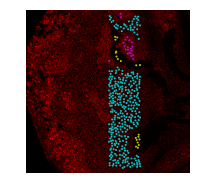

In [81]:
# create axis
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize=(3, 3))
_ = layer.get_channel('r').show(ax=ax, segments=False, cmap=None)
_ = ax.axis('off')
cmap = ListedColormap(['y', 'c', 'm'], 'indexed', 3)


ax.scatter(cells.centroid_x, cells.centroid_y, c=cells.genotype, cmap=cmap, vmin=0, vmax=2, s=1)

fig.savefig('../graphics/cells_included.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)

In [89]:
tickpad = 0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['xtick.major.pad'] = tickpad
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['ytick.major.pad'] = tickpad
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['ytick.direction'] = 'out'

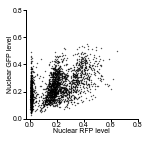

In [103]:
exp = df[df.experiment=='control']

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(exp.r, exp.g, s=0.1, c='k')
_ = ax.set_xticks(np.arange(0, .95, .2))
_ = ax.set_yticks(np.arange(0, .95, .2))
_ = ax.set_xlabel('Nuclear RFP level', fontsize=7)
_ = ax.set_ylabel('Nuclear GFP level', fontsize=7)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)

#fig.savefig('../graphics/control_correlation.pdf', dpi=300, format='pdf', transparent=True, rasterized=True)